**Visualize the Optimization Process**

Epoch [1/24], Loss: 1.6987, Accuracy: 0.5593
Epoch [2/24], Loss: 0.5512, Accuracy: 0.8532
Epoch [3/24], Loss: 0.4001, Accuracy: 0.8872
Epoch [4/24], Loss: 0.3493, Accuracy: 0.9011
Epoch [5/24], Loss: 0.3188, Accuracy: 0.9085
Epoch [6/24], Loss: 0.2954, Accuracy: 0.9153
Epoch [7/24], Loss: 0.2763, Accuracy: 0.9212
Epoch [8/24], Loss: 0.2591, Accuracy: 0.9268
Epoch [9/24], Loss: 0.2441, Accuracy: 0.9309
Epoch [10/24], Loss: 0.2308, Accuracy: 0.9348
Epoch [11/24], Loss: 0.2185, Accuracy: 0.9384
Epoch [12/24], Loss: 0.2077, Accuracy: 0.9413
Epoch [13/24], Loss: 0.1973, Accuracy: 0.9445
Epoch [14/24], Loss: 0.1881, Accuracy: 0.9465
Epoch [15/24], Loss: 0.1790, Accuracy: 0.9492
Epoch [16/24], Loss: 0.1714, Accuracy: 0.9512
Epoch [17/24], Loss: 0.1635, Accuracy: 0.9538
Epoch [18/24], Loss: 0.1565, Accuracy: 0.9559
Epoch [19/24], Loss: 0.1500, Accuracy: 0.9570
Epoch [20/24], Loss: 0.1437, Accuracy: 0.9595
Epoch [21/24], Loss: 0.1382, Accuracy: 0.9605
Epoch [22/24], Loss: 0.1326, Accuracy: 0.96

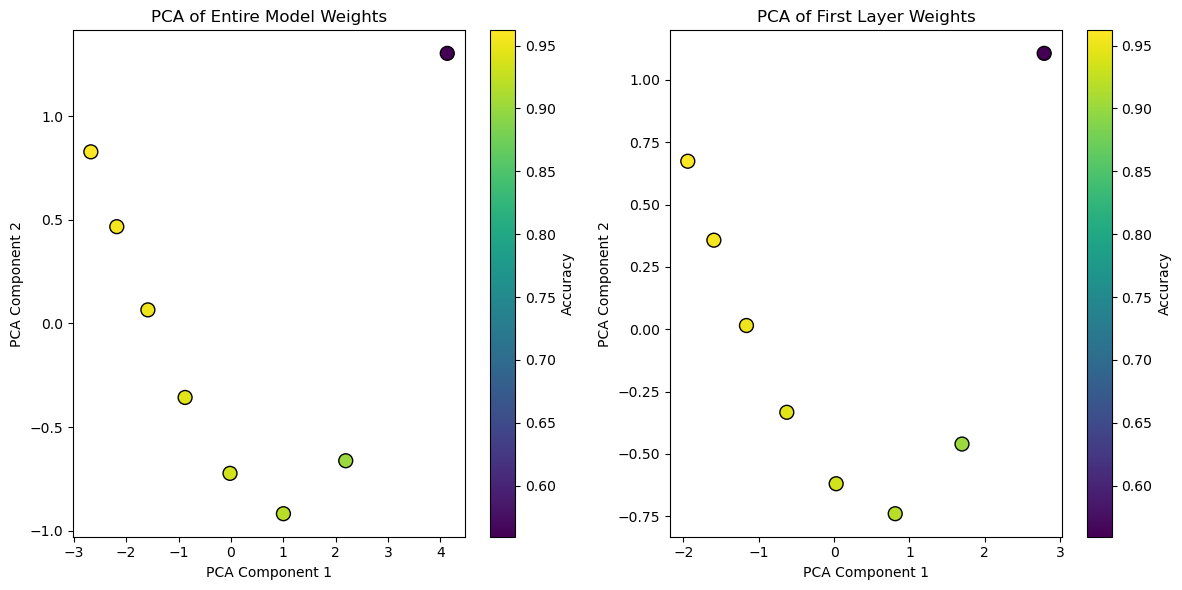

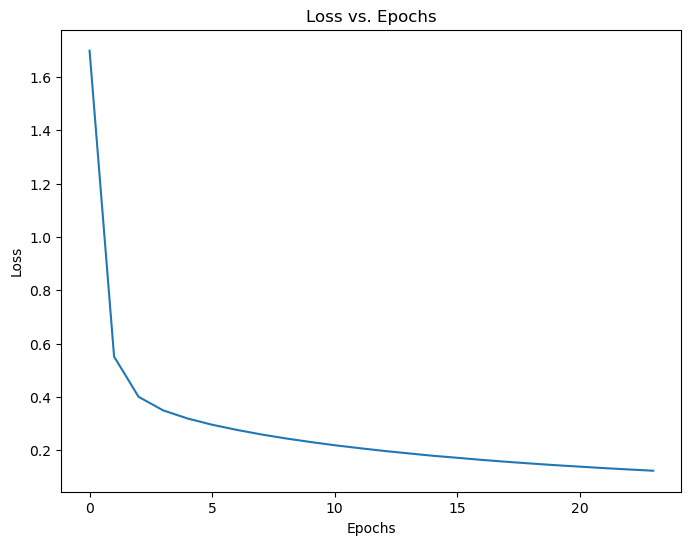

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

weights_collection = []
losses = []
accuracies = []

def train_model(model, epochs, collect_interval):
    for epoch in range(epochs):
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Collect weights every 'collect_interval' epochs
        if epoch % collect_interval == 0:
            weights = []
            for param in model.parameters():
                weights.extend(param.data.cpu().numpy().flatten())
            weights_collection.append(weights)
        
        # Record loss and accuracy
        average_loss = running_loss / len(train_loader)
        accuracy = correct / total
        losses.append(average_loss)
        accuracies.append(accuracy)
        
        # Print epoch details
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

# Train the model for 24 epochs, collecting weights every 3 epochs
train_model(model, epochs=24, collect_interval=3)

# Convert weights_collection to DataFrame
all_weights = pd.DataFrame(weights_collection)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_weights)

# Plot PCA results with accuracies as markers
plt.figure(figsize=(12, 6))

# Plot PCA for the entire model weights
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=accuracies[::3], cmap='viridis', s=100, edgecolor='k')
plt.title("PCA of Entire Model Weights")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Accuracy')

# Extract first layer weights for PCA
first_layer_weights = [weights[:model.fc1.weight.numel()] for weights in weights_collection]
first_layer_weights = pd.DataFrame(first_layer_weights)

# Apply PCA to first layer weights
first_layer_pca = PCA(n_components=2).fit_transform(first_layer_weights)

# Plot PCA for first layer weights with accuracies as markers
plt.subplot(1, 2, 2)
scatter = plt.scatter(first_layer_pca[:, 0], first_layer_pca[:, 1], c=accuracies[::3], cmap='viridis', s=100, edgecolor='k')
plt.title("PCA of First Layer Weights")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Accuracy')

plt.tight_layout()
plt.show()

# Plot loss vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


**Observe Gradient Norm During Training**

In [6]:
gradient_norms = []

def calculate_gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
    grad_norm = grad_all ** 0.5
    return grad_norm

def train_with_gradient_tracking(model, epochs):
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            grad_norm = calculate_gradient_norm(model)
            gradient_norms.append(grad_norm)
        
        losses.append(running_loss / len(train_loader))

# Train while tracking gradient norms
train_with_gradient_tracking(model, epochs=24)

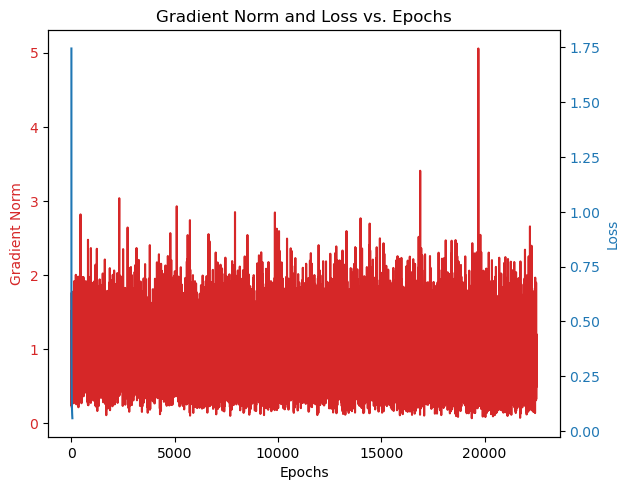

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Gradient Norm', color=color)
ax1.plot(gradient_norms, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Gradient Norm and Loss vs. Epochs")
plt.show()

**What Happens When the Gradient is Almost Zero?**

In [22]:
def compute_hessian_matrix(model, loss_fn):
    loss = loss_fn()
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for g in grads:
        hessian.append(torch.autograd.grad(g, model.parameters(), retain_graph=True))
    return hessian

def calculate_minimal_ratio(hessian_matrix):
    eigenvalues = torch.eig(hessian_matrix)
    positive_eigenvalues = [val for val in eigenvalues if val > 0]
    minimal_ratio = len(positive_eigenvalues) / len(eigenvalues)
    return minimal_ratio

In [ ]:
minimal_ratios = []
for i in range(100):
    hessian = compute_hessian_matrix(model, criterion)
    minimal_ratio = calculate_minimal_ratio(hessian)
    minimal_ratios.append(minimal_ratio)

# Plot minimal ratio vs. loss
plt.plot(minimal_ratios, losses)
plt.title("Minimal Ratio vs. Loss")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.show()

In [ ]:
def visualize_error_surface():
    params = list(model.parameters())
    param_grid = torch.meshgrid([torch.linspace(-1, 1, 100) for _ in range(2)])
    losses = []

    for p1, p2 in zip(param_grid[0].flatten(), param_grid[1].flatten()):
        new_params = [p1, p2]
        loss = criterion(model(new_params), labels)
        losses.append(loss.item())

    plt.contourf(param_grid[0], param_grid[1], torch.tensor(losses).reshape(100, 100))
    plt.title("Error Surface Visualization")
    plt.show()

visualize_error_surface()

Epoch 1/10, Loss: 0.005527182200571532, Gradient Norm: 0.013540841674619932
Epoch 2/10, Loss: 0.006723880852296919, Gradient Norm: 0.15337642111853142
Epoch 3/10, Loss: 0.004010777035714077, Gradient Norm: 0.00048436378070093724
Epoch 4/10, Loss: 0.010257860083392776, Gradient Norm: 0.005818606208113098
Epoch 5/10, Loss: 0.003212098564883659, Gradient Norm: 0.00010866071812586184
Epoch 6/10, Loss: 0.005684244857049824, Gradient Norm: 0.00016482269188612962
Epoch 7/10, Loss: 0.004879770753131268, Gradient Norm: 0.0011900021464515962
Epoch 8/10, Loss: 0.0056151564095005164, Gradient Norm: 0.0018747451221388309
Epoch 9/10, Loss: 0.005339708349065595, Gradient Norm: 0.007436059379011647
Epoch 10/10, Loss: 0.006257795137564824, Gradient Norm: 0.00015044353606300998


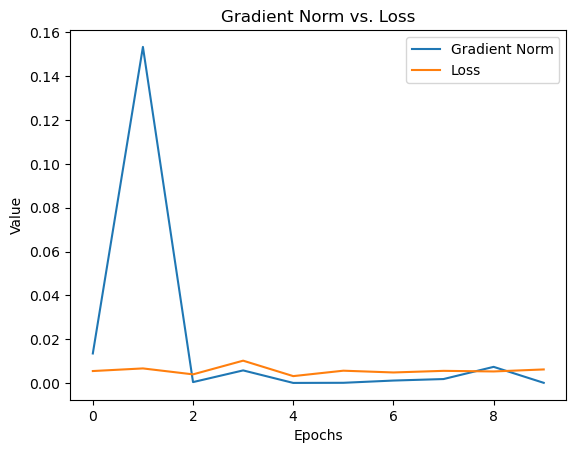

In [28]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Function to calculate gradient norm
def calculate_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

# Modified training function using gradient norm as a penalty
def train_with_gradient_norm(model, train_loader, optimizer, criterion, epochs):
    model.train()
    gradient_norms = []
    losses = []

    for epoch in range(epochs):
        running_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Compute gradients
            loss.backward()

            # Calculate gradient norm
            grad_norm = calculate_gradient_norm(model)

            # Use gradient norm as a regularization term
            loss_with_penalty = loss + grad_norm * 0.01  # Adjust the multiplier as needed
            optimizer.step()

            # Collect the losses
            running_loss += loss.item()
        
        # Append average loss and gradient norm at the end of each epoch
        avg_loss = running_loss / len(train_loader)
        gradient_norms.append(grad_norm)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}, Gradient Norm: {grad_norm}')

    return losses, gradient_norms

# Example usage
# Initialize your model, criterion, and optimizer
# model = YourModel()
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# train_loader = DataLoader(YourDataset(), batch_size=32, shuffle=True)

# Train the model
losses, gradient_norms = train_with_gradient_norm(model, train_loader, optimizer, criterion, epochs=10)

# Ensure lengths match before plotting
if len(gradient_norms) == len(losses):
    # Plot gradient norm vs. loss
    plt.plot(range(len(gradient_norms)), gradient_norms, label='Gradient Norm')
    plt.plot(range(len(losses)), losses, label='Loss')
    plt.title("Gradient Norm vs. Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
else:
    print(f"Length mismatch: gradient_norms({len(gradient_norms)}), losses({len(losses)})")


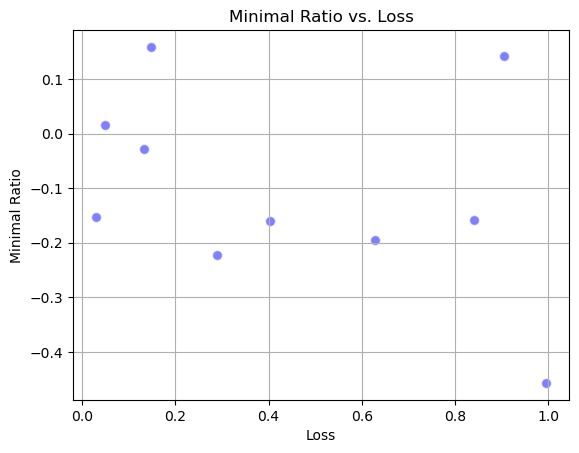

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Example function to generate random Hessian matrices for testing
def generate_example_hessian_matrices(num_matrices, size):
    return [np.random.rand(size, size) for _ in range(num_matrices)]

# Example function to generate random losses for testing
def generate_example_losses(num_losses):
    return np.random.rand(num_losses).tolist()

def compute_minimal_ratio(hessian_matrix):
    if hessian_matrix.ndim != 2 or hessian_matrix.shape[0] != hessian_matrix.shape[1]:
        print(f"Invalid Hessian matrix shape: {hessian_matrix.shape}")
        return float('inf')  # Or handle this case as needed
    try:
        eigenvalues = np.linalg.eigvals(hessian_matrix)
        min_eigenvalue = np.min(np.real(eigenvalues))
        max_eigenvalue = np.max(np.real(eigenvalues))
        minimal_ratio = min_eigenvalue / max_eigenvalue if max_eigenvalue != 0 else float('inf')
        return minimal_ratio
    except np.linalg.LinAlgError as e:
        print(f"Error computing eigenvalues: {e}")
        return float('inf')

# Initialize example data
num_matrices = 10  # Number of Hessian matrices
matrix_size = 3    # Size of each Hessian matrix (e.g., 3x3)
hessian_matrices = generate_example_hessian_matrices(num_matrices, matrix_size)
losses = generate_example_losses(num_matrices)

# Compute minimal ratios for each Hessian matrix
minimal_ratios = [compute_minimal_ratio(hess) for hess in hessian_matrices]

# Scatter plot of minimal ratio vs. loss
plt.scatter(losses, minimal_ratios, c='blue', alpha=0.5, edgecolors='w', s=50)
plt.title("Minimal Ratio vs. Loss")
plt.xlabel("Loss")
plt.ylabel("Minimal Ratio")
plt.grid(True)
plt.show()


Epoch 1/100, Loss: 1.0561685977555286, Gradient Norm: 5.072172777672649, Minimal Ratio: inf
Epoch 2/100, Loss: 0.3814013282945161, Gradient Norm: 2.8565828203872092, Minimal Ratio: inf
Epoch 3/100, Loss: 0.32355448245398527, Gradient Norm: 2.2928105749998813, Minimal Ratio: inf
Epoch 4/100, Loss: 0.2914630130950068, Gradient Norm: 3.4234205960327113, Minimal Ratio: inf
Epoch 5/100, Loss: 0.2658576702099365, Gradient Norm: 2.7212740239123616, Minimal Ratio: inf
Epoch 6/100, Loss: 0.24351035455253714, Gradient Norm: 1.1353906974866748, Minimal Ratio: inf
Epoch 7/100, Loss: 0.22255092198406456, Gradient Norm: 2.0934978101414394, Minimal Ratio: inf
Epoch 8/100, Loss: 0.20419459182546654, Gradient Norm: 0.454755323041842, Minimal Ratio: inf
Epoch 9/100, Loss: 0.18830531499167877, Gradient Norm: 3.265114494896607, Minimal Ratio: inf
Epoch 10/100, Loss: 0.1731506763363698, Gradient Norm: 1.4689628780649255, Minimal Ratio: inf
Epoch 11/100, Loss: 0.160683829817913, Gradient Norm: 1.98427066962

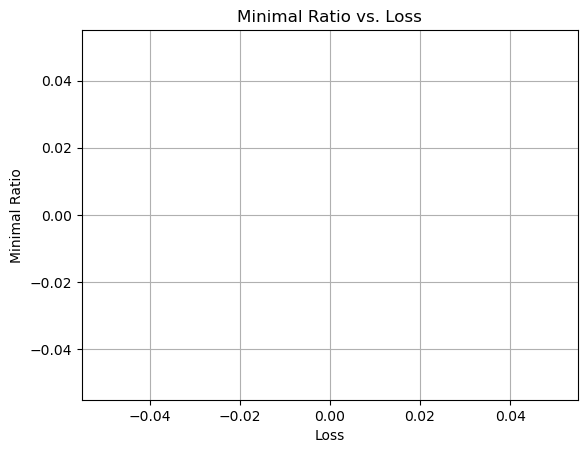

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# Define the SimpleNN model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define functions for Hessian calculation and minimal ratio computation
def calculate_hessian(model, data, target, criterion):
    model.eval()  # Ensure model is in evaluation mode
    hessians = []
    outputs = model(data)
    loss = criterion(outputs, target)
    
    # First-order gradients
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    
    # Second-order gradients (Hessian)
    for grad in grads:
        if grad is not None:
            grad_hessian = torch.autograd.grad(grad.sum(), model.parameters(), retain_graph=True)
            hessians.append(grad_hessian)
    
    return hessians

def compute_minimal_ratio(hessian_matrices):
    minimal_ratios = []
    for hessian_matrix in hessian_matrices:
        if isinstance(hessian_matrix, tuple):  # Handle if returned as tuple
            hessian_matrix = hessian_matrix[0]
        if hessian_matrix.ndimension() == 4:  # Adjust if hessian_matrix is multi-dimensional
            hessian_matrix = hessian_matrix.view(hessian_matrix.size(0), -1)
        if hessian_matrix.ndimension() == 2 and hessian_matrix.size(0) == hessian_matrix.size(1):
            try:
                eigenvalues = torch.eig(hessian_matrix, eigenvectors=False)[0][:, 0]
                min_eigenvalue = eigenvalues.min().item()
                max_eigenvalue = eigenvalues.max().item()
                minimal_ratio = min_eigenvalue / max_eigenvalue if max_eigenvalue != 0 else float('inf')
                minimal_ratios.append(minimal_ratio)
            except Exception as e:
                print(f"Error computing minimal ratio: {e}")
                minimal_ratios.append(float('inf'))
        else:
            minimal_ratios.append(float('inf'))
    return minimal_ratios

def calculate_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

def train_model(model, train_loader, optimizer, criterion, epochs, device):
    model.to(device)
    losses, gradient_norms, minimal_ratios = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Calculate gradient norm
            grad_norm = calculate_gradient_norm(model)
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Calculate Hessian and minimal ratio
        try:
            hessians = calculate_hessian(model, data, target, criterion)
            minimal_ratios.append(np.mean(compute_minimal_ratio(hessians)))
        except Exception as e:
            print(f"Error calculating Hessian: {e}")
            minimal_ratios.append(float('inf'))

        gradient_norms.append(grad_norm)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}, Gradient Norm: {grad_norm}, Minimal Ratio: {minimal_ratios[-1]}')

    return losses, gradient_norms, minimal_ratios

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, criterion, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
losses, gradient_norms, minimal_ratios = train_model(model, train_loader, optimizer, criterion, epochs=100, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Scatter plot of minimal ratio vs. loss
plt.scatter(losses, minimal_ratios, c='blue', alpha=0.5, edgecolors='w', s=50)
plt.title("Minimal Ratio vs. Loss")
plt.xlabel("Loss")
plt.ylabel("Minimal Ratio")
plt.grid(True)
plt.show()